Example of the Empirical Variability Model class: compare the Empirical Model with observations of the excess variance as a function of luminosity. This examples uses functions from the genfun.py module

In [1]:
import sys
sys.path.append("..")
import ensvar as var
import genfun 
import astropy.io.fits as fits
import numpy

Read the mock AGN catalogue as wll as the datapoints from figure 5 for Paolillo+2017 (https://ui.adsabs.harvard.edu/abs/2017MNRAS.471.4398P/abstract)

In [2]:
hdu = fits.open("../DATA/SIM_AIRD15_VAR_PHOT.fits")
data=hdu[1].data
hdu.close()
D = genfun.readDATA("../DATA/data_Fig5_Paolillo+2017.dat")

Read the Paolillo+17 CDFS-7Ms selection function CDFS-7Ms. Then assign weights to the mock AGN based on that selection function. The relevant column in the  mock catalogue is the 'FT", which is the 0.5-7keV flux of each mock AGN. 

In [3]:
# the lines below can be uncommented to take into 
# account the Paolillo+17 CDFS-7Ms selection function
# They create weights for each mock AGN which
# represent the probability of beinh inlcuded in the
# Paolillo+17 CDFS-7Ms variability sample. 

hdu = fits.open("../DATA/CDF7Ms_selection.fits")
lgf=hdu[1].data['LGFLUX057']
prob = hdu[1].data['PROB']
hdu.close()
weight = numpy.interp(data['FT'], lgf, prob)

Set up the Empirical Variability Model in the redshift range 0.4-4 and for the variability timescales 0.25-6205 days. The adopted black-hole mass vs stellar-mass scaling relation is that of Savorgnan+16, GETMBHMSTAR_SAV_SIGMA. The redshift interval and the timescales are the same as in Paolillo+2017.

In [4]:
Model = 'Model3'
ZMIN= 0.4
ZMAX= 4.0
DMINOBS=0.25;DMAXOBS=6205
EM=var.EmpMo(data=data, ZMIN=ZMIN, ZMAX=ZMAX, PSDfun=Model, MMfun=var.GETMBHMSTAR_SAV_SIGMA, LEDDfun=var.GETLGLEDD)
EM.updateSTRUCT()
EM.sigma2(DMINOBS, DMAXOBS)

# converts 2-10keV luminosity to 0.5-7keV luminosity used by Paolillo+17. This conversion assumes
# a power-law with G=1.9
EM.DSTRUCT['LGLX'] = EM.DSTRUCT['LGLX'] + numpy.log10(1.593)

# assign weigths to each mock AGN that account for the selection funcion
EM.DSTRUCT['WEIGHTS'] = weight

Estimate the ensemble variance (mean of excess variance of individual sources) in luminosity bins of 0.5dex

In [5]:
dlglx = 0.5
bins=numpy.arange(41,47, dlglx)
DTMINOBS=numpy.array([0.25]);DTMAXOBS=numpy.array([6205])
array=numpy.ndarray([bins.size])
array.fill(1e-10)

indeces = numpy.digitize(EM.DSTRUCT['LGLX'], bins)
possible = numpy.unique(indeces)
for j in possible:
    if(j>0 and j<bins.size):
        ci = indeces == j
        array[j-1] = numpy.average(a=EM.DSTRUCT['SIGMA2O'][ci], weights=EM.DSTRUCT['WEIGHT'][ci])


Plot results

Text(0.18, 0.23, '$M_{star}-M_{BH}$:  Savorgnan+16 ')

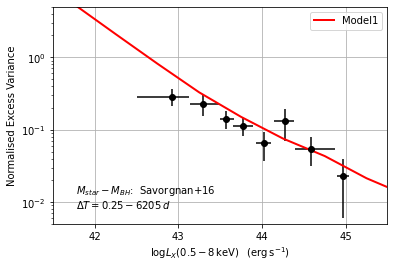

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
            

xobs = D['LGLX']
xerr = [D['LGLX']-D['LGLXMIN'], D['LGLXMAX']-D['LGLX']]
yerr= [numpy.minimum(D['ESIG2'], D['SIG2']*.99), D['ESIG2']]
yobs=D['SIG2']
           
ax.errorbar(xobs, yobs, xerr=xerr, yerr=yerr, fmt='o', c="k")        
            
ax.plot(bins+dlglx/2, array, "-", color='red', linewidth=2.0, label='Model1')
        
ax.set_yscale('log');ax.set_yscale('log')
ax.axis([41.5,45.5,0.005,5])
ax.xaxis.set_ticks([42,43,44,45])
ax.grid()
ax.legend()
ax.set_xlabel(r'$\log L_X(\rm 0.5-8\,keV)\;\;\; (erg\,s^{-1}$)')
ax.set_ylabel(r'Normalised Excess Variance')
plt.figtext(0.18, 0.18, r"$\Delta T={} - {}\,d$".format(DMINOBS, DMAXOBS))
plt.figtext(0.18, 0.23, r'$M_{star}-M_{BH}$:  Savorgnan+16 ')    

The same comparison using all 4 PSD models of Paolillo+17 can be done by calling the genfun.plotmodel function.

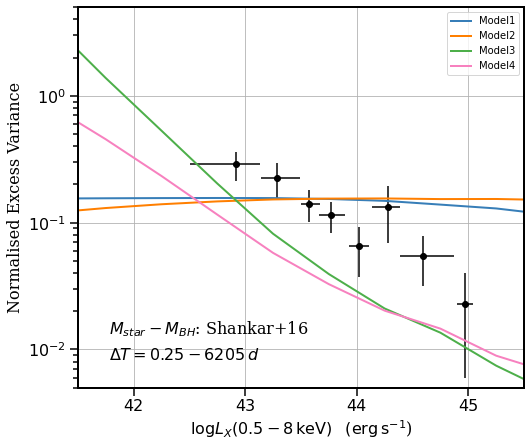

In [7]:
genfun.plotmodel()